# [LAB-10] 11.이원분산분석 (Two way ANOVA)

두 개의 명목형 요인이 연속형 종속변수의 평균에 어떤 영향을 미치는지, 그리고 두 요인간 상호작용 효과가 존재하는지를 검정하는 통계 방법


분석을 수행하기 전에는 일원분산분석과 동일하게 정규성과 등분산성 등의 기본 가정이 충족되어야한다

이원 분산분석의 주요 목적은 상호작용 효과의 존재 여부를 파악하는 데 있으므로 수준이 개 이상인 요인의 주효과가 유의할 떄 해당 요인에 대해서만 사후검정을 수행한다





### #01. 준비작업
#### [1] 패키지 참조

In [3]:
from hossam import load_data
from pandas import melt, DataFrame
from matplotlib import pyplot as plt
from matplotlib import font_manager as fm
import seaborn as sb
from math import sqrt


# 가정 확인을 위한 라이브러리
from scipy.stats import t, normaltest, bartlett, levene


# 분산분석을 위한 라이브러리
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
from pingouin import anova
from pingouin import welch_anova


# 사후검정을 위한 라이브러리
from pingouin import pairwise_tukey, pairwise_tests, pairwise_gameshowell

#### [2] 그래프 초기화

In [4]:
#한글을 지원하는 폰트 파일의 경로
font_path ='C:\\Data_Analysis_Basic\\[LAB-06] 데이터 시각화 개요\\NotoSansKR-Regular.ttf'
#폰트의 그룹을 시스템에 등록
fm.fontManager.addfont(font_path)
#폰트의 속성을 읽어옴
font_prop = fm.FontProperties(fname=font_path)
#읽어온 속성에서 폰트의 이름만 추출
font_name = font_prop.get_name()

#이미지의 선명도를 결정 (1인치 당 픽셀의 수)
my_dpi = 120 
#시스템에 등록된 글꼴 이름  (상단에서 확인한 폰트 이름으로 넣기)
my_font_name = 'Noto Sans KR'
#그림 스타일 지정
my_theme = 'dark'
#seaborn 스타일 (화풍 설정하기)
sb.set_theme(style=my_theme)
#그래프에 한글 폰트 적용
plt.rcParams['font.family']=my_font_name
#기본 폰트 크기
plt.rcParams['font.size'] =16
#그래프에 마이너스 꺠짐 방지 (한글환경에서 필수)
plt.rcParams['axes.unicode_minus']=False

### 03 예제1 - 햇빛 노출과 관수 빈도에 따른 식물 성장의 영향 알아보기
한 식물학자는 식물의 성장이 햇빛 노출과 관수 빈도에 의해 영향을 받는지 여부를 알고 싶어한
다.
실험은 씨앗을 심고 햇빛 노출과 물 주기를 다른 조건으로 하여 두 달 동안 자라게 한 후 각 식물
의 높이를 인치 단위로 기록하였다.

#### [1] 데이터 가져오기

In [5]:
origin = load_data('sunlight_watering_growth')
print("\n===== 데이터 크기 확인 =====")
print(f"데이터셋 크기: {origin.shape}")
print(f"열 개수: {origin.shape[1]}")
print(f"행 개수: {origin.shape[0]}")
print("\n===== 타입확인 =====")
print(origin.info())
origin.head()

[data] https://data.hossam.kr/data/lab10_/sunlight_watering_growth.xlsx
[desc] 식물의 씨앗을 심고 햇빛 노출과 물 주기를 다른 조건으로 하여 두 달 동안 자라게 한 후 각 식물의 높이를 인치 단위로 기록한 데이터 (출처: 방송통신대학교 통계학개론)

field    description
-------  ----------------------------------------------------------------
water    각 식물에 물을 주는 빈도 (매일:`daily`, 매주: `weekly`)
sun      각 식물이 받은 햇빛 노출량 (낮음:`low`, 중간:`med`, 높음:`high`)
height   2개월 후 각 식물의 높이 (인치)


===== 데이터 크기 확인 =====
데이터셋 크기: (120, 3)
열 개수: 3
행 개수: 120

===== 타입확인 =====
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120 entries, 0 to 119
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   water   120 non-null    object 
 1   sun     120 non-null    object 
 2   height  120 non-null    float64
dtypes: float64(1), object(2)
memory usage: 2.9+ KB
None


,water,sun,height
0,daily,low,4.9
1,daily,low,7.9
2,daily,low,3.9
3,daily,low,5.1
4,daily,low,5.2


> 이원분산분석에 적합한 형태는 melt 처리된 형태이다

#### [2] 데이터 분포 시각화
(1) 관수빈도별 햇빛 노출 빈도에 따른 식물 높이 비교




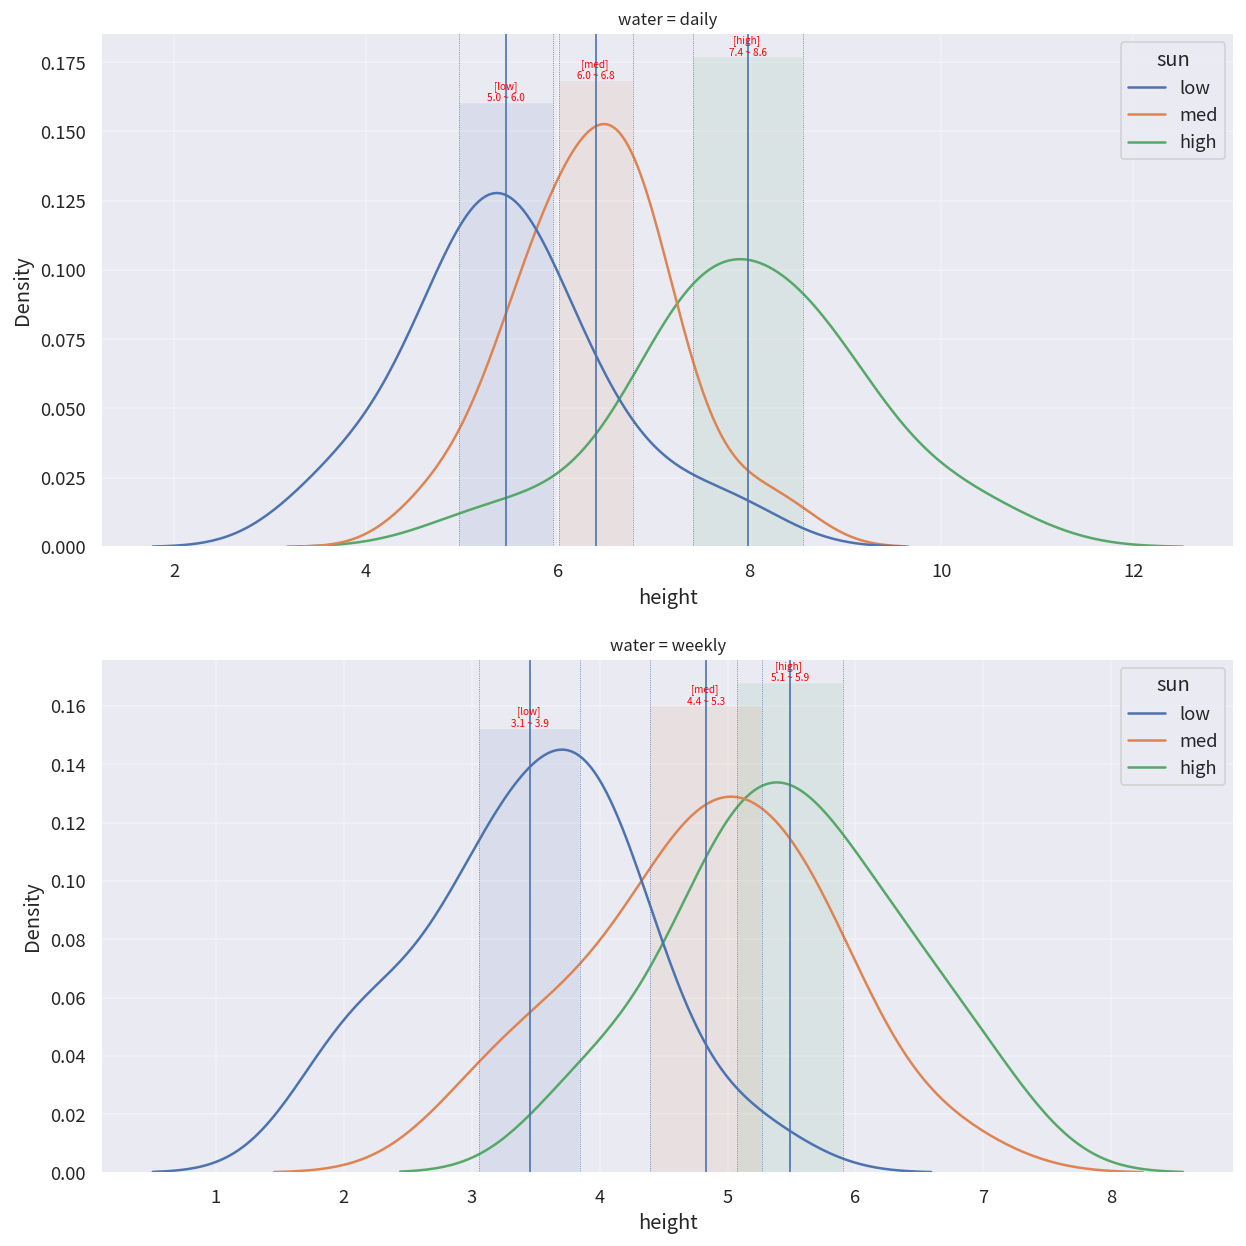

In [6]:
field = 'height'
group_field = 'water'
hue_field = 'sun'

# 시각화 할 필드만 원본 데이터에서 추출
data = origin[[field, group_field, hue_field]]

group_values = data[group_field].unique()
group_count = len(group_values)
hue_values = data[hue_field].unique()

# 1) 그래프 초기화
rows = group_count                  # 그래프 행 수
cols = 1 # 그래프 열 수
width_px  = 1280 * cols             # 그래프 가로 크기
height_px = 640* rows              # 그래프 세로 크기
figsize = (width_px / my_dpi, height_px / my_dpi)

# ax 객체가 행,열 수에 따라서 리스트가 된다.
fig, ax = plt.subplots(rows, cols, figsize=figsize, dpi=my_dpi)

# 2) 그래프 그리기
for i, v in enumerate(group_values):
    temp = data[data[group_field] == v]
    sb.kdeplot(data=temp, x=field, hue=hue_field, ax=ax[i])
    ax[i].grid(True, alpha=0.3)
    ax[i].set_title('{0} = {1}'.format(group_field, v), fontsize=10, pad=5)

    for h in hue_values:
        temp_sub = temp[temp[hue_field] == h]
        
        # 신뢰구간
        max = temp_sub[field].max()                         # 최대값
        clevel = 0.95 # 신뢰수준
        dof = len(temp_sub[field]) -1 # 자유도
        sp_mean = temp_sub[field].mean()                    # 표본평균
        sp_std = temp_sub[field].std(ddof=1)                # 표본표준편차
        sp_std_error = sp_std / sqrt(len(temp_sub[field]))  # 표본표준오차
        
        cmin, cmax = t.interval(clevel, dof, loc=sp_mean, scale=sp_std_error)
        
        ax[i].axvline(cmin, linestyle=':', linewidth=0.5)
        ax[i].axvline(cmax, linestyle=':', linewidth=0.5)
        
        # 평균 표시
        ymin, ymax = ax[i].get_ylim()
        ax[i].fill_between([cmin, cmax], 0, ymax, alpha=0.1)
        ax[i].axvline(sp_mean, linestyle='-', linewidth=1)
        
        # 텍스트 그리기
        ax[i].text(x=(cmax-cmin)/2+cmin,
                y=ymax,
                s="[%s] \n%0.1f ~ %0.1f" % (h, cmin, cmax),
                horizontalalignment="center",
                verticalalignment="bottom",
                fontdict={"size": 6, "color": "red"})

# 4) 출력
plt.tight_layout()      
plt.show()              
# 여백 제거
# 그래프 화면 출력
plt.close()             
# 그래프 작업 종료

(2) 햇빛 노출 빈도별 관수량에 따른 식물 높이 비교

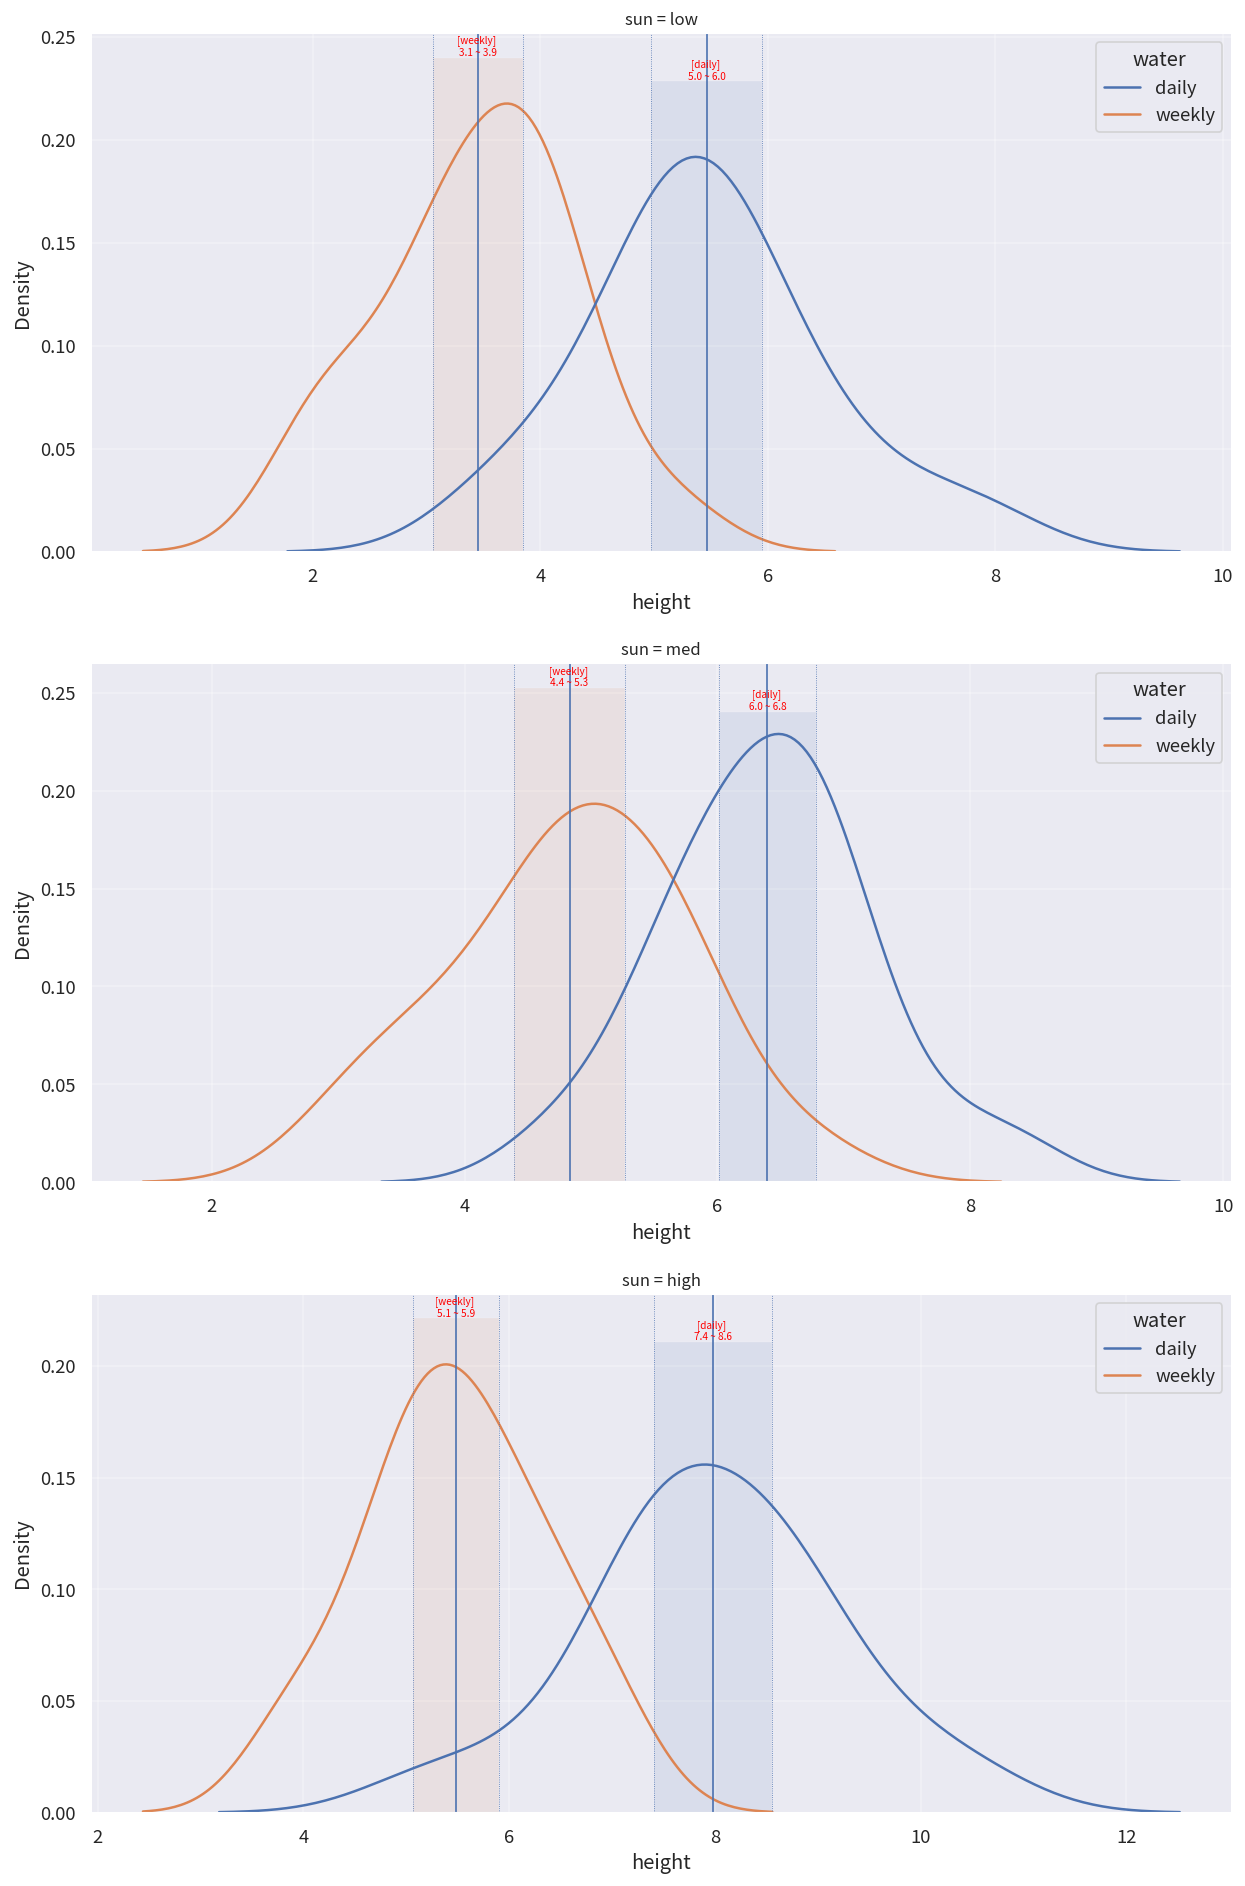

In [7]:

# (참고) origin, my_dpi 변수는 이 코드 이전에 선언되어 있어야 합니다.

field = 'height'
group_field = 'sun'
hue_field = 'water'

# 시각화 할 필드만 원본 데이터에서 추출
data = origin[[field, group_field, hue_field]]
group_values = data[group_field].unique()
group_count = len(group_values)
hue_values = data[hue_field].unique()

# 1) 그래프 초기화
rows = group_count                  # 그래프 행 수
cols = 1                            # 그래프 열 수
width_px  = 1280 * cols             # 그래프 가로 크기
height_px = 640 * rows              # 그래프 세로 크기
figsize = (width_px / my_dpi, height_px / my_dpi)

# ax 객체가 행,열 수에 따라서 리스트가 된다.
fig, ax = plt.subplots(rows, cols, figsize=figsize, dpi=my_dpi)

# 2) 그래프 그리기
for i, v in enumerate(group_values):
    temp = data[data[group_field] == v]
    sb.kdeplot(data=temp, x=field, hue=hue_field, ax=ax[i])
    ax[i].grid(True, alpha=0.3)
    ax[i].set_title('{0} = {1}'.format(group_field, v), fontsize=10, pad=5)

    for h in hue_values:
        temp_sub = temp[temp[hue_field] == h]
        
        # 신뢰구간
        max = temp_sub[field].max()                         # 최대값
        clevel = 0.95                                       # 신뢰수준
        dof = len(temp_sub[field]) - 1                      # 자유도
        sp_mean = temp_sub[field].mean()                    # 표본평균
        sp_std = temp_sub[field].std(ddof=1)                # 표본표준편차
        sp_std_error = sp_std / sqrt(len(temp_sub[field]))  # 표본표준오차
        
        cmin, cmax = t.interval(clevel, dof, loc=sp_mean, scale=sp_std_error)
        
        ax[i].axvline(cmin, linestyle=':', linewidth=0.5)
        ax[i].axvline(cmax, linestyle=':', linewidth=0.5)
        
        # 평균 표시
        ymin, ymax = ax[i].get_ylim()
        ax[i].fill_between([cmin, cmax], 0, ymax, alpha=0.1)
        ax[i].axvline(sp_mean, linestyle='-', linewidth=1)
        
        # 텍스트 그리기
        ax[i].text(x=(cmax-cmin)/2+cmin,
                y=ymax,
                s="[%s] \n%0.1f ~ %0.1f" % (h, cmin, cmax),
                horizontalalignment="center",
                verticalalignment="bottom",
                fontdict={"size": 6, "color": "red"})

# 4) 출력
plt.tight_layout()      # 여백 제거
plt.show()              # 그래프 화면 출력
plt.close()             # 그래프 작업 종료

(3) 분산분석의 가정 확인

In [8]:
data = origin.copy()
xname = ['water', 'sun']
yname = 'height'

u1 = data[xname[0]].unique()
u2 = data[xname[1]].unique()
equal_var_fields = []
normal_dist = True
report = []

for i in u1:
    for j in u2:
        filtered_data = data[(data[xname[0]] == i) & (data[xname[1]] == j)][yname]
        equal_var_fields.append(filtered_data)
        s, p = normaltest(filtered_data)

        normalize = p > 0.05
        report.append({
            "field": "{0}, {1}".format(i, j),
            "statistic": s,
            "p-value": p,
            "result": normalize
        })
        normal_dist = normal_dist and normalize

if normal_dist:
    n = "Bartlett"
    s, p = bartlett(*equal_var_fields)
else:
    n = "Levene"
    s, p = levene(*equal_var_fields)

equal_var = p > 0.05

report.append({
    "field": n,
    "statistic": s,
    "p-value": p,
    "result": p > 0.05
})

report_df = DataFrame(report).set_index('field')
report_df

,statistic,p-value,result
field,,,
"daily, low",1.461514,0.481544,True
"daily, med",0.866582,0.648372,True
"daily, high",0.801917,0.669678,True
"weekly, low",0.073958,0.963697,True
"weekly, med",0.160764,0.922764,True
"weekly, high",0.052520,0.974082,True
Bartlett,4.488400,0.481437,True


#### [4] 이원분산분석
1) 분산분석 결과 생성

In [9]:
xname = ['water' , 'sun']
yname = 'height'


pg_anova=anova(data=origin , dv = yname , between = xname)
pg_anova

,Source,SS,DF,MS,F,p-unc,np2
0,water,122.816333,1,122.816333,130.528994,1.301312e-20,0.533798
1,sun,103.292167,2,51.646083,54.889371,2.013276e-17,0.490568
2,water * sun,4.327167,2,2.163583,2.299453,1.049489e-01,0.038777
3,Residual,107.264000,114,0.940912,NaN,NaN,NaN


네, 원본 이미지의 텍스트가 붙어있어 보기 불편하셨을 텐데, 바로 복사해서 사용하실 수 있도록 깔끔하게 정리된 **마크다운(Markdown)** 포맷으로 드리겠습니다.

아래 내용을 복사하시면 됩니다.

***

### 1. 주요 지표 설명

* **SS (Sum of Squares, 제곱합)**
    * 데이터가 평균으로부터 얼마나 퍼져 있는지를 나타내는 값입니다.
    * 각 데이터 값과 평균의 차이를 제곱하여 모두 더한 값으로, **변동성(Variation)**의 크기를 의미합니다.

* **DF (Degrees of Freedom, 자유도)**
    * 통계적 추정을 할 때 자유롭게 값을 가질 수 있는 데이터의 개수입니다.
    * 보통 `(집단 수 - 1)` 또는 `(전체 데이터 수 - 집단 수)` 등의 방식으로 계산됩니다.

* **MS (Mean Square, 평균제곱)**
    * 제곱합(SS)을 자유도(DF)로 나눈 값입니다 ($MS = SS \div DF$).
    * 데이터의 **분산(Variance)**을 추정하는 값으로 사용됩니다.

* **F (F-value, F통계량)**
    * `집단 간 분산(MS) / 집단 내 분산(MS)`의 비율입니다.
    * 이 값이 클수록 **"집단 간의 차이가 우연이 아니라 실제로 존재할 가능성"**이 높다는 뜻입니다.

* **p-unc (Uncorrected p-value, 유의확률)**
    * 귀무가설(집단 간 차이가 없다)이 맞을 확률입니다.
    * 보통 **0.05(5%)보다 작으면** "집단 간에 통계적으로 유의미한 차이가 있다"고 판단합니다.

* **np2 (Partial Eta Squared, 편에타제곱)**
    * 효과 크기(Effect Size)를 나타내는 지표입니다.
    * 독립변수(원인)가 종속변수(결과)의 변동을 **몇 퍼센트나 설명하는지**를 보여줍니다.
    * 예: 0.53이면 약 53%의 설명력을 가짐.

2. 결과문장생성


In [10]:
for idx in pg_anova.index:
  row = pg_anova.iloc[idx]
  source = row['Source']
  p_val = row['p-unc']

  if p_val <= 0.05:
    print (f"→ {source} 효과는 유의함. (대립가설 채택: p ≤ 0.05)")
  else:
    print(f"→ {source} 효과는 유의하지 않음. (귀무가설 채택: p > 0.05)")

→ water 효과는 유의함. (대립가설 채택: p ≤ 0.05)
→ sun 효과는 유의함. (대립가설 채택: p ≤ 0.05)
→ water * sun 효과는 유의하지 않음. (귀무가설 채택: p > 0.05)
→ Residual 효과는 유의하지 않음. (귀무가설 채택: p > 0.05)


ANOVA 는 데이터를 설명되는 부분과 설명되지 않는 부분으로 나눈다

총 제곱합 (SS TOTAL) = 요인 A 로 설명되는 부분 + 요인 B 로 설명되는 부분 + 상호작용 (A*B) 로 설명되는 부분 + 남은 부분 (RESIDUAL)

RESIDUAL = 모델이 설명할 수 없는 개별 오차
- 동일 조건인데도 식물 키가 조금씩 다른 지연변동
- 측정 오차
- 눈에 보이지 않는 다른 요인들
- 모델에서는 고려하지 않은 모든 외부 영향



Residual df 와 함께 모델의 품질을 보여줌
- Residual[SS] = 107.264
- Residual[DF] = 114
- Residual[MS] = 0.941

> 각 조건에서 개체 간 차이는 평균적으로 약 0.94 정도의 변동을 가진다는 뜻
> 모델이 설명한 변동이 훨씬 크므로 주효과(water, sun)의 F값이 매우 큼


- 잔차가 작을수록 모델의 설명력이 높다고 해석함
- Residual은 ANOVA 모델이 설명하지 못한 오차(개체 간 자연 변동 + 측정 오차 등)를 의
미하며, F-통계량을 계산하는 기준이 되는 값이다.


3) 사후검정

In [11]:


# 데이터 준비
xname = ['water', 'sun']
yname = 'height'
data = origin[xname + [yname]]

# 1) 각 요인의 수준(집단) 개수 파악
levels = {}   
for factor in xname:                     
    level_count = data[factor].nunique() # 요인의 수준 수 계산
    levels[factor] = level_count         # 딕셔너리에 저장 ({'water': 2, 'sun': 3})

# 2) ANOVA 결과에서 p-value 추출
pvals = {}   
for index, row in pg_anova.iterrows():     
    source_name = row['Source']            
    p_value = row['p-unc']                 
    pvals[source_name] = p_value         # 딕셔너리에 저장 ({'water': 1.3e-20...})

# 3) 주효과에 대한 사후검정 판단 자동화
for factor in xname:
    print(f"\n[{factor}]")
    
    # 수준이 2개 이하이면 사후검정 불필요 (t-test와 동일하거나 평균 차이만 보면 됨)
    # 오타 수정: /= 2 -> <= 2
    if levels[factor] <= 2:
        print(f"- {levels[factor]}수준 요인이므로 사후검정이 필요 없습니다.")
        continue

    # 해당 요인의 p-value 가져오기
    p_val = pvals.get(factor, None)
    
    if p_val is None:
        print("- ANOVA 결과에서 해당 요인을 찾을 수 없습니다.")
        continue
    
    # 유의하지 않으면 사후검정 생략
    if p_val > 0.05:
        print(f"- 주효과 유의하지 않음 (p={p_val:.3g}) → 사후검정 수행 안 함")
        continue
    
    # 유의한 경우 사후검정 수행
    print(f"- 주효과 유의 (p={p_val:.3g}) → 사후검정 수행")
    
    # 등분산 여부(equal_var)는 앞선 코드에서 정의되었다고 가정
    if equal_var:
        print("  · Tukey HSD 사용 (등분산 충족)")
        hoc_df = pairwise_tukey(data=data, dv=yname, between=factor)
    else:
        print("  · Games–Howell 사용 (등분산 불충족)")
        hoc_df = pairwise_gameshowell(data=data, dv=yname, between=factor)
    
    display(hoc_df)

# 4) 상호작용 효과 판단 자동화
interaction_names = [src for src in pvals.keys() if '*' in src]

for inter in interaction_names:
    p_val = pvals[inter]
    print(f"\n[{inter}] 상호작용 효과")
    
    # 오타 수정: /= 0.05 -> < 0.05 (유의확률 기준)
    if p_val < 0.05:
        print(f"- 상호작용 유의 (p={p_val:.3g}) → 단순주효과 분석 필요")
    else:
        print(f"- 상호작용 유의하지 않음 (p={p_val:.3g}) → 단순주효과 분석 필요 없음")


[water]
- 2수준 요인이므로 사후검정이 필요 없습니다.

[sun]
- 주효과 유의 (p=2.01e-17) → 사후검정 수행
  · Tukey HSD 사용 (등분산 충족)


,A,B,mean(A),mean(B),diff,se,T,p-tukey,hedges
0,high,low,6.7325,4.4600,2.2725,0.316503,7.180027,2.079377e-10,1.480100
1,high,med,6.7325,5.6125,1.1200,0.316503,3.538671,1.663237e-03,0.775153
2,low,med,4.4600,5.6125,-1.1525,0.316503,-3.641356,1.172021e-03,-0.888359



[water * sun] 상호작용 효과
- 상호작용 유의하지 않음 (p=0.105) → 단순주효과 분석 필요 없음


### #03.인사이트
#### 1.분석목적
본 분석은 {DV}에 대해 {요인들}이 어떠한 영향을 미치는지를 검증하기 위해 분산분석(ANOVA)
을 수행하였다.

> 본 분석은 식물의 높이(height)에 대해 관수 빈도(water)와 햇빛 노출(sun)이 어떤 영향을 미치는지 평가하기 위해 이원분산분석(two-way ANOVA)을 수행하였다

### 2. 분산분석 주요 결과
2-1 요인별 유의성 판단

- {요인1}: F = {F값}, p = {p값}, ηp² = {효과크기} → {유의성 판단}- {요인2}: F = {F값}, p = {p값}, ηp² = {효과크기} → {유의성 판단}- {상호작용}: F = {F값}, p = {p값}, ηp² = {효과크기} → {유의성 판단}
(**요약:**) {핵심 요약문 1–2문장}


- water: F = 130.53, p = 1.30e-20, ηp² = 0.534 → 유의함(대립가설 채택)
- sun: F = 54.89, p = 2.01e-17, ηp² = 0.491 → 유의함(대립가설 채택)
- water × sun: F = 2.30, p = 0.105, ηp² = 0.039 → 유의하지 않음(귀무가설 채택)


물주기와 햇빛은 식물 높이에 모두 유의한 영향을 주지만, 두 요인이 결합해 특별한 상호작용 효과를 만들어내지는 않는다

### 3. 기술통계 및 집단별 평균 비교 

- {요인1} 수준별 평균: …
- {요인2} 수준별 평균: …
- 상호작용 조합 평균(해당 시): …
(**요약 해석:**) {패턴 설명}



- water 수준별 평균
daily: 6.63
weekly: 4.57

→ 매일 물 준 그룹이 크게 성장함.


- sun 수준별 평균
low: 4.44
med: 5.61
high: 6.73

→ 햇빛이 많을수록 뚜렷한 증가.
 
| water | low | med | high |
| :--- | :---: | :---: | :---: |
| **daily** | 5.40 | 6.41 | 7.88 |
| **weekly** | 3.46 | 4.67 | 5.52 |

> 두 요인의 증가 방향은 거의평행한 형태로 나타나 상호작용이 약하다는 점을 뒷받침한다

### 4. 사후검정 (Post-hoc) 결과

- {요인1}: {수준 수}수준 → {사후검정 여부 및 이유}
- {요인2}: {사후검정 결과 요약}
- 상호작용(simple effects): {필요 여부}
(**요약 해석:**) {사후검정으로 확인된 구체적 차이}

- water ; 2 수준 요인이므로 사후검정 불필요
- sun : 3수준 + 주효과 유의 --> Tukey HSD 수행

결과 
- high > low (차이 2.27, p < .001)
- high > med (차이 1.12, p < .01)
-  med > low (차이 1.15, p < .01)

- 상호작용 : P=0.105 --> 단순 주효과 분석 불필요
햇빛의 세 조건은 서로 모두 유의하게 다른 평균을 가진다

### 5. 최종 결론 요약
- • {핵심 인사이트 1}- 
- • {핵심 인사이트 2}- 
- • {핵심 인사이트 3}- 
- • {모형의 의미 있는 해석}
(**최종 한 문장 결론:**) {DV}는 {주요 요인}의 영향을 크게 받으며, {상호작용 여부}가 확
인되었다.



- 관수(water)는 식물의 성장에 강력한 영향을 줌(매일 물을 줄수록 더 큼).
- 햇빛(sun)은 명확한 선형적 효과를 가지며, high > med > low 순으로 성장 증가.
- 두 요인이 결합해 상승효과를 만드는 상호작용은 없음.
- 사후검정 결과, 햇빛 조건 세 그룹은 모두 서로 유의하게 차이가 있음
- 식물의 높이는 관수 빈도와 햇빛 수준의 영향을 크게 받으며, 두 요인은 독립적으로 작용하여 성장 패턴을 결정한다
